<a href="https://colab.research.google.com/github/francobarrionuevoenv21/CA_implt_GPU/blob/main/GPUvsSeq_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.1 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=9b146c6a05c0e63f4a4d63759f42b883dee253bf23bb20240c782e081d7ace1b
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


In [2]:
# PYCUDA LIBRARIES
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [3]:
# GENERAL PURPOSES LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import time

# Project Description

This project consist in the implementation of a basic Cellular Automaton (CA) for wildfire propagation that runs on GPUs using PyCUDA. The implementation performed is based on the [Julius Wons'](https://github.com/jcwons/Wildfire-Mapping-and-Simulation-with-Cellular-Automaton) project. To asses the improvement of running the CA in GPUs, it is then calculated how much faster is this approach versus the sequential one.

##### **Cellular Automaton**

A [cellular automaton](https://natureofcode.com/cellular-automata/#what-is-a-cellular-automaton) is a model of a system of cell objects with the following characteristics:

*   The cells live on a grid
*   Each cell has a state. The number of possible states is typically finite. The simplest example has the two possibilities of 1 and 0 (otherwise referred to as on and off, or alive and dead).
* Each cell has a neighborhood. This can be defined in any number of ways, but it is typically all the cells adjacent to that cell.
* It is defined a transition function (rules that determine how a cell updates based on its state and its neighbors)

##### **Implementation constraints**

As it is a basic implementation, at this stage only for exploring PyCUDA capabilities, the burn probality (transition function) will be defined as a function of the NDVI.

$p_{burn} = p_0 * f_{NDVI}$

Where

*   $p_{burn}$: burn probability
*   $p_0$: base ignition probability
*   $f_{NDVI}$: multiplicative factor

### **Notebook goals**

The objective here is to compare the performance of the GPU and the Sequential implementation for differents escenarios (i.e. different data sized given as NxN). Each case will involve running the implementation for the whole matrix, it means iterations (T) = N/2

# 1. Defining CA GPU implementation

In [4]:
# @title CA implementation Kernel

mod = SourceModule ("""
    __global__ void compute_AC(int *state, int *old_state, float *p_burn, float *randm, int rows, int cols){
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < rows && col < cols) {
        int i = row * cols + col;

        if (old_state[i] == 2){
              state[i] = 2;
        } else if (old_state[i] == 1) {
            state[i] = 2;
        } else if (
            (row > 0 && old_state[i - cols] == 1) || // Up
            (row < rows-1 && old_state[i + cols] == 1) || // Down
            (col > 0 && state[i - 1] == 1) || // Left
            (col < cols-1 && old_state[i + 1] == 1) || // Right
            (row > 0 && col > 0 && old_state[i - cols - 1] == 1) || // Up-left
            (row > 0 && col < cols-1 && old_state[i - cols + 1] == 1) || // Up-right
            (row < rows-1 && col > 0 && old_state[i + cols - 1] == 1) || // Down-left
            (row < rows-1 && col < cols-1 && old_state[i + cols + 1] == 1) // Down-right
        ) {

          if (randm[i] < p_burn[i]) {
            state[i] = 1;
          } else {
            state[i] = 0;
          }
        } else {
          state[i] = 0;
        }
      }
    }
    """)

In [6]:
# @title CA GPU running function

def CA_GPUimpl_dt(cols, rows, T, state, p_burn, random_p):

  # START TIME GPU IMPLEMENTATION
  start_GPU = time.time()

  # GET THE KERNEL FUNCTION
  compute_AC = mod.get_function("compute_AC")

  # ALLOCATE GPU MEMORY
  state_gpu = drv.mem_alloc(state.nbytes)
  state_old_gpu = drv.mem_alloc(state.nbytes)
  pburn_gpu = drv.mem_alloc(p_burn.nbytes)
  randm_gpu = drv.mem_alloc(random_p[0].nbytes)

  # COPY INITIAL DATA TO GPU
  drv.memcpy_htod(state_gpu, state_GPU)
  drv.memcpy_htod(state_old_gpu, state_GPU)
  drv.memcpy_htod(pburn_gpu, p_burn)

  # DEFINE BLOCK AND GRID DIMENSIONS
  block_dim = (32, 32, 1) # max threads per block: 1024 (32x32)
  grid_dim = ((cols + block_dim[0] - 1) // block_dim[0],
            (rows + block_dim[1] - 1) // block_dim[1], 1)

  # TIME LOOP. For future instances, this can be implemented with tensors instead of 2D matrices
  for t in range(T):

      drv.memcpy_htod(randm_gpu, random_p[t])

      # Launch kernel
      compute_AC(
          state_gpu,
          state_old_gpu,
          pburn_gpu,
          randm_gpu,
          np.int32(rows),
          np.int32(cols),
          block=block_dim,
          grid=grid_dim
      )

      # COPY CURRENT STATE TO OLD STATE
      drv.memcpy_dtod(state_old_gpu, state_gpu, state.nbytes)


  # COPY FINAL RESULTS BACK TO CPU
  result = np.empty_like(state)
  drv.memcpy_dtoh(result, state_gpu)

  # END TIME GPU IMPLEMENTATION
  end_GPU = time.time()

  return end_GPU-start_GPU

# 2. Defining CA Sequential implementation

In [8]:
# @title CA Sequential running function

def CA_SeqImpl_dt(cols, rows, T, state, p_burn, random_p):
  # START TIME SEQ IMPLEMENTATION
  start_SEQ = time.time()

  # AC IMPLEMENTATION, ITERATING OVER EACH PIXEL
  for i_t in range(T):
      new_state = state.copy()  # buffer for the new step
      for i in range(rows):
          for j in range(cols):
              if state[i, j] == 2:
                  new_state[i, j] = 2
              elif state[i, j] == 1:
                  new_state[i, j] = 2
              elif (i + 1 < rows and state[i+1, j] == 1) or \
                  (i - 1 >= 0 and state[i-1, j] == 1) or \
                  (j + 1 < cols and state[i, j+1] == 1) or \
                  (j - 1 >= 0 and state[i, j-1] == 1) or \
                  (i + 1 < rows and j + 1 < cols and state[i+1, j+1] == 1) or \
                  (i - 1 >= 0 and j - 1 >= 0 and state[i-1, j-1] == 1) or \
                  (i + 1 < rows and j - 1 >= 0 and state[i+1, j-1] == 1) or \
                  (i - 1 >= 0 and j + 1 < cols and state[i-1, j+1] == 1):
                  if random_p[i_t, i, j] < p_burn[i, j]:
                      new_state[i, j] = 1
                  else:
                      new_state[i, j] = 0
              else:
                  new_state[i, j] = 0
      state = new_state  # update after the full step

  # START TIME SEQ IMPLEMENTATION
  end_SEQ = time.time()

  return end_SEQ-start_SEQ

# 3. CA implementations assesment (Toy data)

### Matrix dimentions to asses in each case

In [10]:
dims_list = [16, 32, 64, 128, 256, 512] #, 1024]#, 2048]

### Toy data generation for each case functions

In [9]:
def gen_stateMx(d):
  # GENERATES A dxd MATRIX WITH state = 0 (non-burnt)
  state_zeros = np.zeros((d, d), dtype=np.int32)

  # DEFINE FIRE START POINT IN THE CENTER
  FP_lon_index = int(d/2)
  FP_lat_index = int(d/2)
  state_zeros[FP_lon_index, FP_lat_index] = 1 # burning: 1

  return state_zeros

def gen_pburnMx(d):

  # VEGETATION TYPE BASED ON TOY DATA. 0.2 VALUE ENSURES A HIGH FLAMMABLE PIXEL
  p_den = np.full((d, d), 0.2, dtype= np.float32)

  return 0.6*(1+p_den) # 0.6 BASELINE THRESHOLD

In [12]:
# INITIALIZE LIST TO SAVE dt DATA
GPUdt_list = list()
Seqdt_list = list()

# RUN CASES ASSESMENTS
for d in dims_list:

  cols = rows = d
  T = int(d/2)

  #print(row, col, T)

  # INITIAL STATE TOY DATA
  state = gen_stateMx(d)

  # BURN PROBABILITY BASED ON VEGETATION TOY DATA
  p_burn = gen_pburnMx(d)

  # RANDOM PROBABILITY
  random_p = np.random.rand(T, d, d).astype(np.float32)

  # MAKE state COPIES
  state_GPU = state.copy()
  state_Seq = state.copy()

  # RUN IMPLEMENTATIONS
  GPUdt_list.append(CA_GPUimpl_dt(cols, rows, T, state_GPU, p_burn, random_p))
  Seqdt_list.append(CA_SeqImpl_dt(cols, rows, T, state_Seq, p_burn, random_p))

# 4. Results visualization

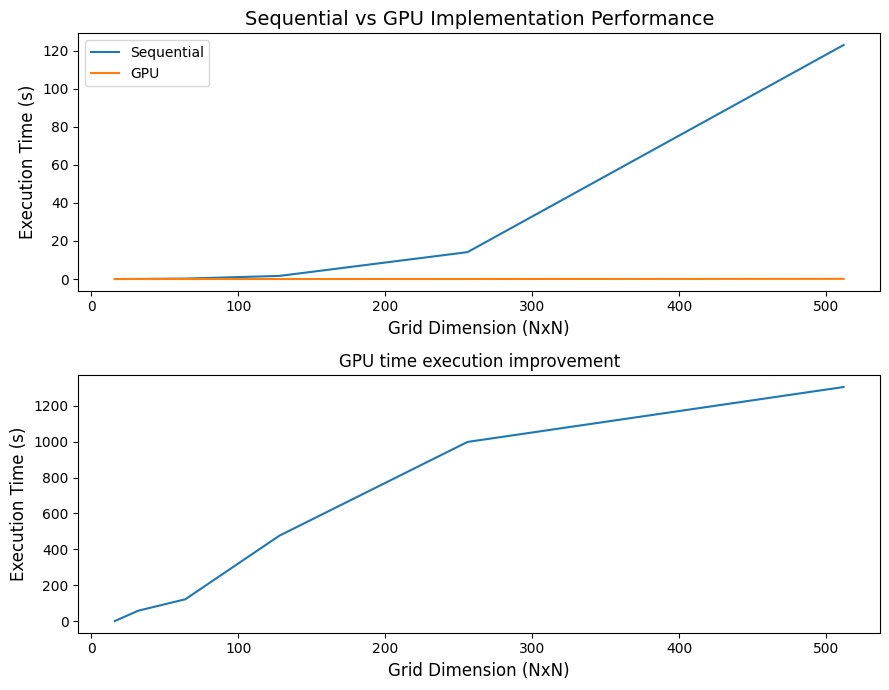

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(9,7))

axs[0].plot(np.array(dims_list), np.array(Seqdt_list), label='Sequential')
axs[0].plot(np.array(dims_list), np.array(GPUdt_list), label='GPU')
axs[0].set_xlabel('Grid Dimension (NxN)', fontsize = 12)
axs[0].set_ylabel('Execution Time (s)', fontsize = 12)
axs[0].set_title('Sequential vs GPU Implementation Performance', fontsize = 14)
axs[0].legend()

axs[1].plot(np.array(dims_list), np.array(Seqdt_list)/np.array(GPUdt_list))
axs[1].set_xlabel('Grid Dimension (NxN)', fontsize = 12)
axs[1].set_ylabel('Execution Time (s)', fontsize = 12)
axs[1].set_title('GPU time execution improvement')

fig.tight_layout()

plt.show()